# Making sense of models using visualization

### Why?
- ***We don't necessarily understand what we create.*** Many theories have been proposed, e.g., [information bottleneck](https://arxiv.org/abs/1503.02406). But most of them are saying it will work well if certain assumptions of your data are true, but nobody knows why they should be true.
- ***Practically, we need to know the boundaries of our models.*** One example is ["NO Need to Worry about Adversarial Examples in Object Detection in Autonomous Vehicles"](https://arxiv.org/pdf/1707.03501.pdf)

### What?
- I cover some simple ways of visualizing two different types of models, namely CNN and seq2seq RNN.
- Those visualization techniques help unerstand the model behaviors to a certain degree.

## 1. Visualize CNN
- VGG16 as an example - clear structure of conv/pool layers that can be explained as image features

### load pretrained VGG16 from [torchvision model zoo](https://github.com/pytorch/vision)
- typical structure of layers of bottleneck features, followed by fully connected classifier layer
- new models might have different structures, e.g., [squeezenet](https://arxiv.org/abs/1602.07360) (squeeze/expand layers), [full-cnn](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) (no more fully-connected layer). Some techniques may need twists for them.

In [112]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import random
import matplotlib.pyplot as plt
import urllib
from io import BytesIO
from PIL import Image
import pandas as pd
from tqdm import tqdm_notebook
from scipy.misc import imresize

import torch
from torch.autograd import Variable
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torchvision import models, transforms

%matplotlib inline

In [2]:
## helper function for display image grid
def display_grid(img_grid, how="mat", cmap=None, img_sz=1.5):
    """img_grid: np.array of size(n_images, w, h)
    """
    nimg = img_grid.shape[0]
    ncol = int(np.sqrt(nimg))
    nrow = int(np.ceil(nimg / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=(img_sz*nrow, img_sz*ncol))
    if nimg > 1:
        axes = axes.ravel()
    else:
        axes = [axes]
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    
    for i in range(nimg):
        if how == "mat":
            axes[i].matshow(img_grid[i, :, :], cmap=cmap)
        else:
            axes[i].imshow(img_grid[i, ...], cmap=cmap)
        axes[i].set_axis_off()

In [3]:
vgg16 = models.vgg16(pretrained=True).cuda()
vgg16

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

Some helper functions

In [85]:
## read ImageNet class names
class_names = urllib.request.urlopen("https://raw.githubusercontent.com/dolaameng/data/master/synset_words.txt").readlines()
class_names = [line.decode("utf-8").strip().split(" ", 1)[-1] for line in class_names]

## image preprocessing for image net models
preprocess = transforms.Compose([
    transforms.Scale([224, 224]),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.485, .456, .406],
                         std=[.229, .224, .225])
])

postprocess = transforms.ToPILImage()

img2var = lambda img: Variable(preprocess(img).unsqueeze(dim=0)).cuda()
def var2img(img_var):
    original_image = img_var.squeeze().cpu().data.numpy().transpose([1, 2, 0])
    mean = np.array([.485, .456, .406])
    std = np.array([.229, .224, .225])
    original_image = original_image * std + mean
    return original_image

## get top n predictions
def top_n_classes(predictions, n=5):
    predictions = predictions.data.cpu().numpy().squeeze()
    classes = np.argsort(predictions)[::-1][:n]
    return pd.DataFrame({"names": [class_names[c] for c in classes], "class": classes})

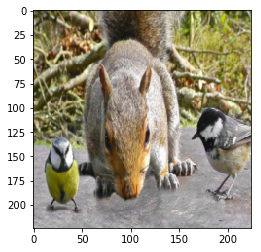

In [86]:
## get an image to test
img_url = 'http://cdn8.openculture.com/wp-content/uploads/2015/11/13212252/cat-and-dog-videos.jpg'
img_bytes = urllib.request.urlopen(img_url).read()
img = Image.open(BytesIO(img_bytes))
# plt.imshow(imresize(img, [224, 224]))
plt.imshow(var2img(img2var(img)))

In [8]:
## test the model 
img_var = img2var(img)

vgg16.eval()
predictions = vgg16(img_var)
top5 = top_n_classes(predictions, n=5)
top5

,class,names
0,987,corn
1,85,quail
2,11,"goldfinch, Carduelis carduelis"
3,335,"fox squirrel, eastern fox squirrel, Sciurus niger"
4,998,"ear, spike, capitulum"


### CNN Visualization 1 - output of hidden layers
- most straightforward to do is just to visualize the output of hidden layers
- intuitively the outputs of lower layers are closer to input images, whereas the higher layers are closer to output class predictions
- pros:
    - directly showing how images are passing through the model
    - to a certain layer, it shows low-level image features such as corners, edges and etc
- cons
    - the higher the layer, the harder to explain
    - but actually the higher layers have richer information towards the model decision

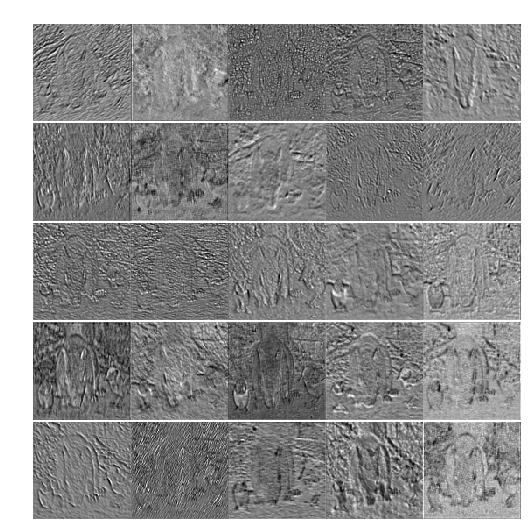

In [9]:
def partial_model(model, ith_layer):
    conv_layers = list(vgg16.children())[0]
    conv_model = nn.Sequential(*[conv_layers[i] for i in range(ith_layer+1)])
    return conv_model

conv7_model = partial_model(vgg16, 7)
conv7_model.eval()
conv7_output = conv7_model(img_var)
conv7_output_data = conv7_output.cpu().data.numpy().squeeze()
display_grid(conv7_output_data[:25], cmap=plt.cm.gray)

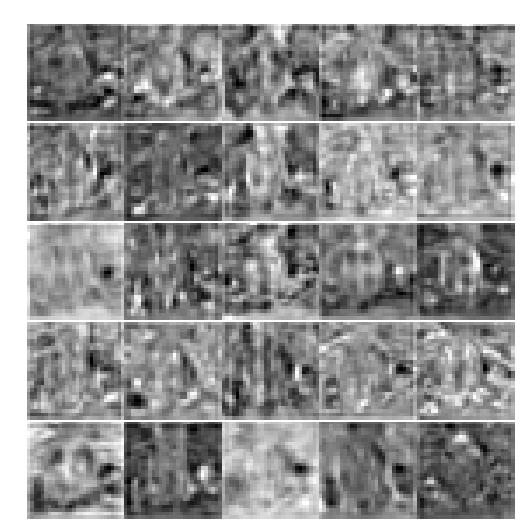

In [10]:
conv21_model = partial_model(vgg16, 21)
conv21_model.eval()
conv21_output = conv21_model(img_var)
conv21_output_data = conv21_output.cpu().data.numpy().squeeze()
display_grid(conv21_output_data[-25:], cmap=plt.cm.gray)

### CNN visualization 2 - inputs that activate certain hidden features
- idea: directly visualizing higher layer of CNN might be hard to explain, we need to be able to map these features back to the original image domain.
- implementation: initialize a blank/random image, enhance its correlation with a certain hidden neuron, by maximizing its activation through the neuron.
- in pytorch, we implement it as
    - define the `negative mean activation of a neuron` as loss
    - optimize it wrt an `input image`
    - similiar idea to [Google's deep dreams](https://github.com/google/deepdream)
- pros:
    - it works better with feature maps from higher layers
- cons:
    - it is still hard to tell how these features are used to make model decisions

In [11]:
def deep_dream(model, n_nodes):
    n_epochs = 100
    
    generated_imgs = []
    
    for node_i in tqdm_notebook(range(n_nodes)):
        ## initial image
        x = Variable(torch.zeros([1, 3, 224, 224])+0.01, requires_grad=True) # avoid deactivating relu?
        cuda_x = x.cuda()
        
        ## optimizer
        optimizer = optim.SGD([x], lr=0.1)

        for epoch in range(n_epochs):
            conv_output = model(x.cuda())
            ## minimize negative mean activation = maximize it
            loss = -torch.mean(conv_output[:,node_i,...])
            loss.backward()
            optimizer.step()
        
        ## generated images
        generated = x.cpu().data.numpy().transpose([0, 2, 3, 1])
        generated = (generated - generated.min()) / (generated.max()-generated.min())
#         generated = (generated + 1) / 2
        generated_imgs.append(generated)
        
    generated_grid = np.concatenate(generated_imgs, axis=0)
    return generated_grid

dreams = deep_dream(conv21_model, 36)

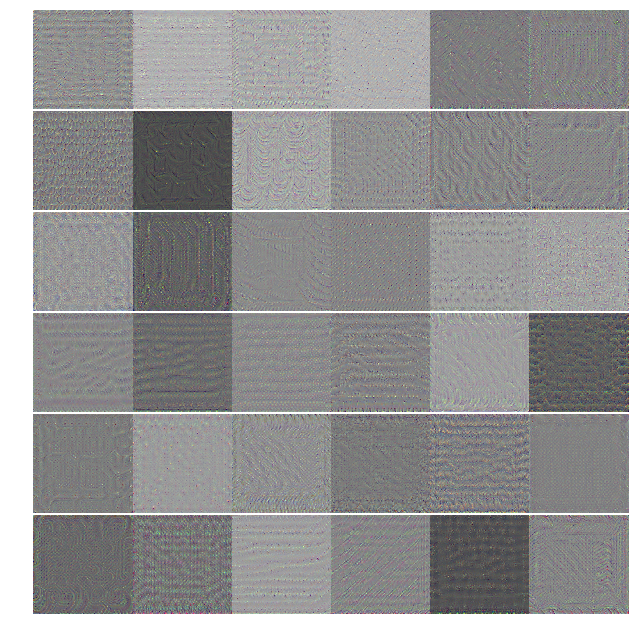

In [12]:
display_grid( dreams, how="img", img_sz=1.5)

### CNN visualization 3 - [classification activation mapping](http://cnnlocalization.csail.mit.edu/)
- idea: instead of looking at the contribution of input image to hidden features, we can look at the contribution of hidden features to the output predictions.
- implementation: 
    - for a certain feature map of shape (HEIGHT x WIDTH x CHANNELS), measure the contribution of each channel as their gradients of prediction wrt their outputs
    - convert a feature map to a heatmap by weighted sum of different channels
    - resize the heatmap and overlap with the original image
- in pytorch, to get the gradient of intermediate (non-leaf) variables :
    - before 0.2.0, you need to use GradientHook as a callback, see [discussion](https://discuss.pytorch.org/t/why-cant-i-see-grad-of-an-intermediate-variable/94/16)
    - after 0.2.0, you can just register your interest of variable graident by `variable.retain_grad()`
- pros:
    - correlates the images with the predictions, and thus provides most meaningful visualization
    - applies to both lower and higher layers
- cons:
    - it highly depends on the structure of CNN, e.g., consider using this with the squeezenet

In [99]:
## VGG16 Wrapper to get the gradients of intermediate layers
class NewVgg16(nn.Module):
    def __init__(self, original_model, inspect_layers):
        super(NewVgg16, self).__init__()
        self.model = original_model
        self.inspect_layers = set(inspect_layers)
        self.inspections = {}
    def forward(self, x):
        ## repeat what a VGG16 does, but add grad infor for variables of interests
        out = x
        for i, layer in enumerate(list(self.model.features.children())):
            out = layer(out)
            if i in self.inspect_layers:
                self.inspections[i] = out
                ## retain the grad for feature map
                self.inspections[i].retain_grad()
        out = out.view([x.size(0), -1])
        out = self.model.classifier(out)
        return out
    
def plot_cam(vgg_model, img_var, ith_layer, threshold = 125):
    
    # evaluate to predictions
    newvgg16 = NewVgg16(vgg_model, [ith_layer]).cuda()
    newvgg16.eval()
    predictions = newvgg16(img_var)
    top_classes = top_n_classes(predictions, n=5) 
    
    # for each of top predictions
    cam_imgs = []
    for i in range(5):

        predictions = newvgg16(img_var)
        loss = predictions[:, top_classes["class"].iloc[i]]
        newvgg16.zero_grad()
        loss.backward(retain_graph=True) # freeze the dynamic graph
        # gradients of predictions wrt ith feature map
        grads = newvgg16.inspections[ith_layer].grad.squeeze()
        # weights as the mean of grads
        n_channels = grads.size(0)
        map_width, map_height = grads.size(1), grads.size(2)
        weights = torch.mean(grads.view([n_channels, -1]), dim=-1).squeeze().cpu().data.numpy()
        # feature map values
        feat_map = newvgg16.inspections[ith_layer].squeeze().cpu().data.numpy()
        # heatmap as weighted sum of different channels
        heatmap = np.matmul(feat_map.reshape([n_channels,-1]).transpose([1, 0]), weights).reshape(map_width, map_height)
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        # resize heatmap to match original
        scaled_heatmap = imresize(heatmap, (224, 224)) >= threshold
        # reconstruct original image from tensor
        original_image = var2img(img_var)
        # overlay prediction heatmap with original
        overlayed = np.stack([0.95*scaled_heatmap*original_image[:,:,i] + 0.05*original_image[:,:,i] 
                      for i in range(3)], axis=2)
        cam_imgs.append(overlayed)
    # plot
    fig, axes = plt.subplots(1, 5, figsize=(5*5, 5))
    axes = axes.ravel()
    for i, (ax, cam_img) in enumerate(zip(axes, cam_imgs)):
        ax.imshow(cam_img)
        ax.set_title(top_classes["names"].iloc[i].split(",")[0])
    return cam_imgs

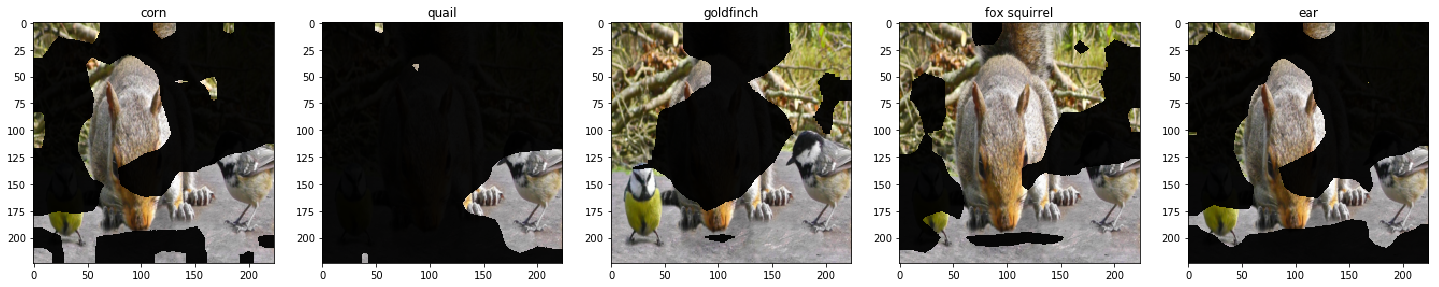

In [100]:
cam_imgs = plot_cam(vgg16, img_var, ith_layer=28)

#### look at lower layers may provide zoom-in details

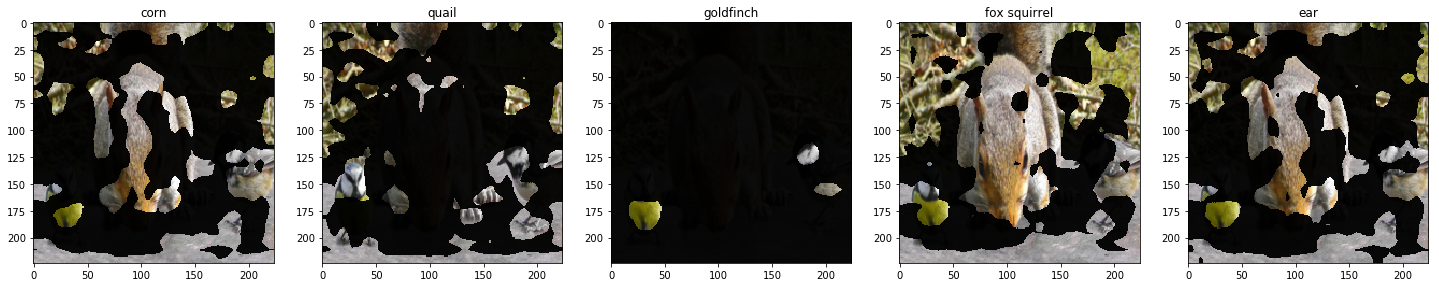

In [101]:
cam_imgs = plot_cam(vgg16, img_var, ith_layer=21)

### Good references
- [cs231n - Visualizing what ConvNets learn](http://cs231n.github.io/understanding-cnn/)
- [Tensorflow object detection API](https://research.googleblog.com/2017/06/supercharge-your-computer-vision-models.html)

## 2. Visualize seq2seq RNN

- Sequences are another common data type, e.g., texts, sensor readings or sometimes events
- seq2seq model maps from one sequence to another by
    - encoder: extracting information from source sequence
    - decoder: translating the extracted information into target sequence
- `attention` provides a simple of correlating the source and the target, e.g. for english-chinese translation, question-answering and etc.
    - it assigns weights for each element pair from the source and target sequences

### Our toy dataset - map an integer sequence to its reverse!
- e.g., `2 3 4 5 6` to `6 5 4 3 2`
- conventions - integers reserved for special meanings:
    - 0: padding
    - 1: start/end of sentences

In [105]:
## generate some data: 
## input - a sequence of integers(index), target: the reverse of it
## for vocabulary setup, reserving index 0 for padding and index 1 for EOS

## this corresponds to skipping the vocab building (word2inex, index2word) and
## use index directly
class ReverseSeqData(Dataset):
    def __init__(self, vocab_size=10, max_seq=10, n_data=1000):
        self.vocab_size = vocab_size
        self.max_seq = max_seq
        self.n_data = n_data
        self.seqs = []
        self.seq_lens = []
        for _ in range(n_data):
            seq_len = np.random.randint(2, max_seq)
            seq = np.zeros(max_seq).astype(np.int64)
            seq[:seq_len] = np.random.randint(2, 10, seq_len) # 0, 1 reserved for padding and EOS
            self.seqs.append(seq)
            self.seq_lens.append(seq_len)
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, i):
        seq = self.seqs[i]
        seq_len = self.seq_lens[i]
        target = np.zeros(self.max_seq + 1).astype(np.int64)
        target[:seq_len+1] = np.array([x for x in seq[:seq_len][::-1]] + [1])
        return (seq, target, seq_len)
    
toy_ds = ReverseSeqData(n_data=50000, max_seq=6)

print(len(toy_ds))
s, t, l = toy_ds[0]
print(s, t, l)

def sort_seqs_by_len(*seqs, lens):
    order = np.argsort(lens)[::-1]
    sorted_seqs = []
    for seq in seqs:
        sorted_seqs.append(np.asarray(seq)[order])
    return sorted_seqs + [np.asarray(lens)[order]]

def get_seq_batches(ds, batch_size=128):
    n = len(ds)
    n_batches = n // batch_size
    index = np.arange(n)
    np.random.shuffle(index)
    for bi in np.array_split(index, n_batches):
        seqs, targets, lens = zip(*[toy_ds[i] for i in bi])
        seqs, targets, lens = sort_seqs_by_len(seqs, targets, lens=lens)
        x, y = torch.from_numpy(seqs), torch.from_numpy(targets)
        yield x, y, lens

50000
[3 4 9 6 7 0] [7 6 9 4 3 1 0] 5


In [128]:
## seq2seq model with attention

############ encoder ##############
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size=8, encoder_hidden_size=16):
        super(Encoder, self).__init__()
        
        self.input_size = input_size
        self.embed_size = embed_size
        self.encoder_hidden_size = encoder_hidden_size
        
        self.embedding = nn.Embedding(input_size, embed_size,
                                      padding_idx=0)
        self.rnn = nn.GRU(input_size=embed_size, hidden_size=encoder_hidden_size,
                          batch_first=True, bidirectional=True)
    def forward(self, x, seq_lens):
        batch_size = x.size(0)
        embed = self.embedding(x)
        padded = pack_padded_sequence(embed, seq_lens, batch_first=True)
        h0 = Variable(torch.zeros([2, batch_size, self.encoder_hidden_size])).cuda()
        out, h = self.rnn(padded, h0)
        out, _ = pad_packed_sequence(out, batch_first=True)
        h = torch.cat([h[1:, ...], h[1:, ...]], dim=-1)
        return out, h

############ attention ##############

## attention, implemented as scoring current decoder output
# with all encoder inputs projected to decoder space, based on their
# inner product
class Attention(nn.Module):
    def __init__(self, output_size, encoder_hidden_size = 16, 
                 decoder_hidden_size = 32):
        super(Attention, self).__init__()
        self.encoder2decoder = nn.Linear(
            encoder_hidden_size*2, # bidirectional
            decoder_hidden_size)
        
    def forward(self, decoder_output, encoder_outputs):
        """
        decoder_output: (batch_size, 1, decoder_hidden_size) of seq length 1
        encoder_outputs: (batch_size, max_seq, 2*encoder_hidden_size) bidirectional
        Returned scores should be of (batch_size, 1, max_seq), so that later they
        can be weighted and sumed by batch matrix multiplication
        """
        batch_size = encoder_outputs.size(0)
        max_len = encoder_outputs.size(1)
        # easier for softmax function for this shape
        scores = Variable(torch.zeros([batch_size, max_len])).cuda()
        
        for b in range(batch_size):
            for s in range(max_len):
                scores[b, s] = self.score(decoder_output[b, 0, :], encoder_outputs[b, s, :])
        
        # cast it to the desired shape
        scores = F.softmax(scores).unsqueeze(dim=1)
        return scores
    
    def score(self, decoder_output, encoder_output):
        projected_encoder = self.encoder2decoder(encoder_output.unsqueeze(dim=0)).squeeze()
        return decoder_output.dot(projected_encoder) 

############ decoder ##############

class AttenDecoder(nn.Module):
    def __init__(self, output_size, output_seq_len, 
                 embed_size=8, encoder_hidden_size=16, decoder_hidden_size=32):
        super(AttenDecoder, self).__init__()
        
        self.output_seq_len = output_seq_len
        
        self.embedding = nn.Embedding(output_size,
                                      embed_size, padding_idx=0)
        self.rnn = nn.GRU(embed_size, decoder_hidden_size, batch_first=True)
        self.attn = Attention(output_size, encoder_hidden_size, decoder_hidden_size)
        self.concat = nn.Linear(decoder_hidden_size*2,
                                decoder_hidden_size)
        self.out = nn.Linear(decoder_hidden_size, output_size)
        
    def forward(self, first_input, first_hidden, encoder_inputs):
        batch_size = encoder_inputs.size(0)
        max_seq = encoder_inputs.size(1)
        
        x, h = first_input, first_hidden
        outs, hiddens, attentions = [], [], []
        for s in range(self.output_seq_len): 
            embeded = self.embedding(x) #->(B, 1, H)
            rnn_out, h = self.rnn(embeded, h) #-> (B, 1, H), (1, B, H)
            attention = self.attn(rnn_out, encoder_inputs) # (B, 1, S)
            context = attention.bmm(encoder_inputs) #->(B, 1, H)
            concat_in = torch.cat([rnn_out, context], dim=-1).squeeze() #->(B, 2H)
            concat_out = F.tanh(self.concat(concat_in)) #->(B, H)
            out = self.out(concat_out) #->(B, C)
            _, x = out.max(dim=1)
            x = x.unsqueeze(dim=1) #->(B, )
            
            outs.append(out)
            attentions.append(attention)
        
        final_out = torch.stack(outs, dim=1) #->(B, S, C)
        final_attention = torch.stack(attentions, dim=2).squeeze() #->(B, output_seq, input_seq)
        return final_out, final_attention
    
############ seq2seq put together ##############
class Seq2Seq(nn.Module):
    def __init__(self, input_size, output_size, output_seq_len,
                 embed_size=8, encoder_hidden_size=16, decoder_hidden_size=32):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_size, embed_size, encoder_hidden_size)
        self.decoder = AttenDecoder(output_size, output_seq_len, 
                 embed_size, encoder_hidden_size, decoder_hidden_size)
    def forward(self, x, seq_lens):
        batch_size = x.size(0)
        encoder_outs, encoder_h = self.encoder(x, seq_lens)
        
        first_input = Variable(torch.zeros([batch_size, 1])).cuda().long()
        decoder_outs, attentions = self.decoder(first_input, encoder_h, encoder_outs)
        
        return decoder_outs, attentions

In [138]:
%%time
## training

batch_size = 128
n_epochs = 1

model = Seq2Seq(input_size=toy_ds.vocab_size,
                output_size=toy_ds.vocab_size,
                output_seq_len=toy_ds.max_seq+1).cuda()
model.train()

objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


for epoch in range(n_epochs):
    batches = get_seq_batches(toy_ds, batch_size=batch_size)
    for b, (bx, by, lens) in enumerate(batches):
        x = Variable(bx).cuda()
        y = Variable(by).cuda()
        yhat, attentions = model(x, lens)
        loss = objective(yhat.view([-1, 10]), y.view([-1]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b % 50 == 0:
            print(epoch, b, loss.data[0])

0 0 2.266113758087158
0 50 1.78510320186615
0 100 1.2138928174972534
0 150 0.8069415092468262
0 200 0.46718305349349976
0 250 0.1653052717447281
0 300 0.07147947698831558
0 350 0.04053497314453125


In [139]:
## evaluation
model.eval()
seqs, targets, lens = zip(*[toy_ds[i] for i in range(20)])
seqs, targets, lens = sort_seqs_by_len(seqs, targets, lens=lens)

x = Variable(torch.from_numpy(seqs)).cuda()
y, attentions = model(x, lens)
_, label = torch.max(y, dim=-1)
print("accuracy:", np.mean(label.data.cpu().numpy() == targets))

accuracy: 1.0


/usr/bin/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


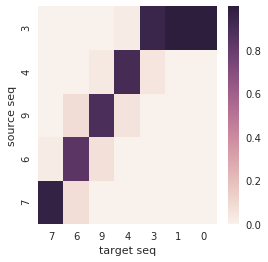

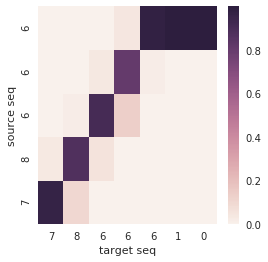

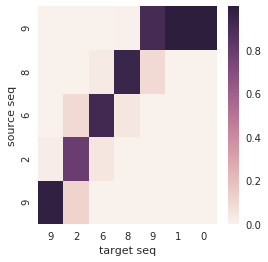

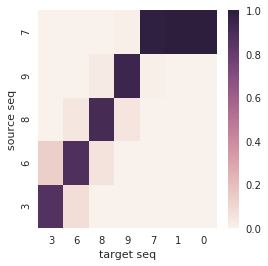

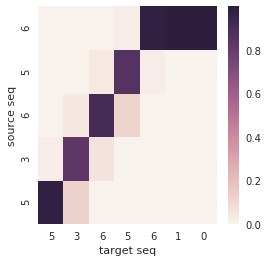

In [149]:
## visualizing attentions
import seaborn as sb

atten_data = attentions.cpu().data.numpy()

for i in range(5):
    plt.figure(figsize=(4, 4))
    cm = pd.DataFrame(atten_data[i], index=label.data.cpu().numpy()[i], columns=seqs[i][:5])
    cm.index.name = "target seq"
    cm.columns.name = "source seq"
    sb.heatmap(cm.T)